In [1]:
import os
import re
import MeCab
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import logging
import warnings 
from google.cloud import storage as gcs
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
%matplotlib inline

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from google.protobuf.pyext import _message


In [2]:
INPUT_BUCKET = 'gs://mj-labeling-questionnaires-dev.datasets.linkbal.com/inputs/ver_01/'
PROJECT_NAME = 'linkbal-dp'
BUCKET_NAME = 'mj-labeling-questionnaires-dev.datasets.linkbal.com' 
client = gcs.Client(PROJECT_NAME)
bucket = gcs.Bucket(client, name=BUCKET_NAME)
jp_stop_words = open("/Users/jesse.ulundo/demo_tests/Japanese_stopword_list.txt", "r")

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
tagger = MeCab.Tagger()

In [4]:
qs = pd.read_csv(INPUT_BUCKET + 'mj_questionnaire_text.csv', sep=',')
qs = qs.dropna()

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
def tokenize_stemmer(text):
    lemmas = []
    for line in tagger.parse(text).splitlines()[:-1]:
        surface, feature = line.split('\t')
        if feature.split(',')[6] != '*':
            lemmas.append(feature.split(',')[6])
    return lemmas

In [6]:
qs['tokenized_overall_satisfaction_reason'] = qs.apply(lambda row: tokenize_stemmer(row['overall_satisfaction_reason']), axis=1)
qs['tokenized_want_recommend_reason'] = qs.apply(lambda row: tokenize_stemmer(row['want_recommend_reason']), axis=1)
qs

,id,overall_satisfaction,overall_satisfaction_reason,want_recommend,want_recommend_reason,tokenized_overall_satisfaction_reason,tokenized_want_recommend_reason
4,111376,6.0,とても楽しかったです\nいろんな人と友達になれたのが◎,10.0,主催のハッピーさんが、とても良かったです。\nまた参加した時にハッピーさんが居ると安心できる...,"[とても, 楽しい, た, です, いろんな, 人, と, 友達, に, なれる, た, の...","[主催, の, ハッピー, さん, が, 、, とても, 良い, た, です, 。, また,..."
5,111377,2.0,店舗スタッフの対応が悪い,2.0,男女比がおかしい（女性が少ない）,"[店舗, スタッフ, の, 対応, が, 悪い]","[男女, 比, が, おかしい, （, 女性, が, 少ない, ）]"
7,111379,2.0,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,3.0,正直、周りの常連さん雰囲気が一人参加だと溶け込みにくいあるグループが生まれた。,"[他, の, の, お, 店, だ, と, 店員, や, 常連, さん, が, 気, を, ...","[正直, 、, 周り, の, 常連, さん, 雰囲気, が, 一, 人, 参加, だ, と,..."
8,111380,4.0,結果が伴ってなかったから,7.0,楽しめたから,"[結果, が, 伴う, てる, ない, た, から]","[楽しめる, た, から]"
11,111383,2.0,大人数なのにマンツーマン、フリータイムが少ない。,0.0,主催者の司会が雑だし、かつ暴言を聞こえない程度にボソッと言われた。,"[大, 人数, だ, のに, マンツーマン, 、, フリー, タイム, が, 少ない, 。]","[主催, 者, の, 司会, が, 雑, だ, し, 、, かつ, 暴言, を, 聞こえる,..."
...,...,...,...,...,...,...,...
20296,131664,1.0,料理の品数が少なすぎた。\nスタッフの対応も最悪。,0.0,ゲームを強制してやらされたが、初対面の人とやる内容ではない。\n,"[料理, の, 品数, が, 少ない, すぎる, た, 。, スタッフ, の, 対応, も,...","[ゲーム, を, 強制, する, て, やらす, れる, た, が, 、, 初対面, の, ..."
20305,131673,3.0,相手の人が少なくて暇な時間がさみしかったです。,1.0,相手の人が少なくて暇な時間がさみしかったです。,"[相手, の, 人, が, 少ない, て, 暇, だ, 時間, が, さみしい, た, です...","[相手, の, 人, が, 少ない, て, 暇, だ, 時間, が, さみしい, た, です..."
20307,131675,1.0,最終的に社長から返金対応する旨の提案を受け、案内を約束されたが未だ待っている状況。\n本当に...,0.0,予約確認メールも届いているのに席が用意されていなかった。\nあまりの対応に参加辞退を申し出た...,"[最終, 的, に, 社長, から, 返金, 対応, する, 旨, の, 提案, を, 受け...","[予約, 確認, メール, も, 届く, て, いる, のに, 席, が, 用意, する, ..."
20308,131676,2.0,水上バスは夜景がきれいだったけど、ほんとにそれだけって感じだった。違和感がありすぎた。,3.0,段取りがあまりよくなくて、人数の割合も合わず、少人数過ぎた。,"[水上, バス, は, 夜景, が, きれい, だ, た, けど, 、, ほんとに, それ,...","[段取り, が, あまり, よい, ない, て, 、, 人数, の, 割合, も, 合う, ..."


In [7]:
stop = [words.strip("\n") for words in jp_stop_words]
stop

['あそこ',
 'あたり',
 'あちら',
 'あっち',
 'あと',
 'あな',
 'あなた',
 'あれ',
 'いくつ',
 'いつ',
 'いま',
 'いや',
 'いろいろ',
 'うち',
 'おおまか',
 'おまえ',
 'おれ',
 'がい',
 'かく',
 'かたち',
 'かやの',
 'から',
 'がら',
 'きた',
 'くせ',
 'ここ',
 'こっち',
 'こと',
 'ごと',
 'こちら',
 'ごっちゃ',
 'これ',
 'これら',
 'ごろ',
 'さまざま',
 'さらい',
 'さん',
 'しかた',
 'しよう',
 'すか',
 'ずつ',
 'すね',
 'すべて',
 'ぜんぶ',
 'そう',
 'そこ',
 'そちら',
 'そっち',
 'そで',
 'それ',
 'それぞれ',
 'それなり',
 'たくさん',
 'たち',
 'たび',
 'ため',
 'だめ',
 'ちゃ',
 'ちゃん',
 'てん',
 'とおり',
 'とき',
 'どこ',
 'どこか',
 'ところ',
 'どちら',
 'どっか',
 'どっち',
 'どれ',
 'なか',
 'なかば',
 'なに',
 'など',
 'なん',
 'はじめ',
 'はず',
 'はるか',
 'ひと',
 'ひとつ',
 'ふく',
 'ぶり',
 'べつ',
 'へん',
 'ぺん',
 'ほう',
 'ほか',
 'まさ',
 'まし',
 'まとも',
 'まま',
 'みたい',
 'みつ',
 'みなさん',
 'みんな',
 'もと',
 'もの',
 'もん',
 'やつ',
 'よう',
 'よそ',
 'わけ',
 'わたし',
 'ハイ',
 '上',
 '中',
 '下',
 '字',
 '年',
 '月',
 '日',
 '時',
 '分',
 '秒',
 '週',
 '火',
 '水',
 '木',
 '金',
 '土',
 '国',
 '都',
 '道',
 '府',
 '県',
 '市',
 '区',
 '町',
 '村',
 '各',
 '第',
 '方',
 '何',
 '的',
 '度',
 '文',
 '者',
 '性',
 '体',
 '人',
 '他',
 '今',
 

In [8]:
qs['cln_tokenized_overall_satisfaction_reason'] = qs['tokenized_overall_satisfaction_reason'].apply(lambda x: [item for item in x if item not in stop])
qs['cln_tokenized_want_recommend_reason'] = qs['tokenized_want_recommend_reason'].apply(lambda x: [item for item in x if item not in stop])
qs

,id,overall_satisfaction,overall_satisfaction_reason,want_recommend,want_recommend_reason,tokenized_overall_satisfaction_reason,tokenized_want_recommend_reason,cln_tokenized_overall_satisfaction_reason,cln_tokenized_want_recommend_reason
4,111376,6.0,とても楽しかったです\nいろんな人と友達になれたのが◎,10.0,主催のハッピーさんが、とても良かったです。\nまた参加した時にハッピーさんが居ると安心できる...,"[とても, 楽しい, た, です, いろんな, 人, と, 友達, に, なれる, た, の...","[主催, の, ハッピー, さん, が, 、, とても, 良い, た, です, 。, また,...","[とても, 楽しい, いろんな, 友達, なれる]","[主催, ハッピー, とても, 良い, また, 参加, ハッピー, 居る, 安心, 友達, ..."
5,111377,2.0,店舗スタッフの対応が悪い,2.0,男女比がおかしい（女性が少ない）,"[店舗, スタッフ, の, 対応, が, 悪い]","[男女, 比, が, おかしい, （, 女性, が, 少ない, ）]","[店舗, スタッフ, 対応, 悪い]","[男女, 比, おかしい, （, 女性, 少ない, ）]"
7,111379,2.0,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,3.0,正直、周りの常連さん雰囲気が一人参加だと溶け込みにくいあるグループが生まれた。,"[他, の, の, お, 店, だ, と, 店員, や, 常連, さん, が, 気, を, ...","[正直, 、, 周り, の, 常連, さん, 雰囲気, が, 一, 人, 参加, だ, と,...","[だ, 店員, 常連, きかせる, 比べる, しまう, どうしても, 多い]","[正直, 周り, 常連, 雰囲気, 参加, だ, 溶け込む, にくい, グループ, 生まれる]"
8,111380,4.0,結果が伴ってなかったから,7.0,楽しめたから,"[結果, が, 伴う, てる, ない, た, から]","[楽しめる, た, から]","[結果, 伴う]",[楽しめる]
11,111383,2.0,大人数なのにマンツーマン、フリータイムが少ない。,0.0,主催者の司会が雑だし、かつ暴言を聞こえない程度にボソッと言われた。,"[大, 人数, だ, のに, マンツーマン, 、, フリー, タイム, が, 少ない, 。]","[主催, 者, の, 司会, が, 雑, だ, し, 、, かつ, 暴言, を, 聞こえる,...","[大, 人数, だ, マンツーマン, フリー, タイム, 少ない]","[主催, 司会, 雑, だ, かつ, 暴言, 聞こえる, 程度, ボソッ, 言う]"
...,...,...,...,...,...,...,...,...,...
20296,131664,1.0,料理の品数が少なすぎた。\nスタッフの対応も最悪。,0.0,ゲームを強制してやらされたが、初対面の人とやる内容ではない。\n,"[料理, の, 品数, が, 少ない, すぎる, た, 。, スタッフ, の, 対応, も,...","[ゲーム, を, 強制, する, て, やらす, れる, た, が, 、, 初対面, の, ...","[料理, 品数, 少ない, すぎる, スタッフ, 対応, 最悪]","[ゲーム, 強制, やらす, 初対面, やる, 内容]"
20305,131673,3.0,相手の人が少なくて暇な時間がさみしかったです。,1.0,相手の人が少なくて暇な時間がさみしかったです。,"[相手, の, 人, が, 少ない, て, 暇, だ, 時間, が, さみしい, た, です...","[相手, の, 人, が, 少ない, て, 暇, だ, 時間, が, さみしい, た, です...","[相手, 少ない, 暇, だ, さみしい]","[相手, 少ない, 暇, だ, さみしい]"
20307,131675,1.0,最終的に社長から返金対応する旨の提案を受け、案内を約束されたが未だ待っている状況。\n本当に...,0.0,予約確認メールも届いているのに席が用意されていなかった。\nあまりの対応に参加辞退を申し出た...,"[最終, 的, に, 社長, から, 返金, 対応, する, 旨, の, 提案, を, 受け...","[予約, 確認, メール, も, 届く, て, いる, のに, 席, が, 用意, する, ...","[最終, 社長, 返金, 対応, 旨, 提案, 受ける, 案内, 約束, 未だ, 待つ, 状...","[予約, 確認, メール, 届く, 用意, あまり, 対応, 参加, 辞退, 申し出る, 悪..."
20308,131676,2.0,水上バスは夜景がきれいだったけど、ほんとにそれだけって感じだった。違和感がありすぎた。,3.0,段取りがあまりよくなくて、人数の割合も合わず、少人数過ぎた。,"[水上, バス, は, 夜景, が, きれい, だ, た, けど, 、, ほんとに, それ,...","[段取り, が, あまり, よい, ない, て, 、, 人数, の, 割合, も, 合う, ...","[水上, バス, 夜景, きれい, だ, けど, ほんとに, だけ, って, だ, 違和感,...","[段取り, あまり, よい, 人数, 割合, 合う, ぬ, 少, 人数, 過ぎる]"


In [9]:
qs_new  = qs[pd.notnull(qs['cln_tokenized_overall_satisfaction_reason'])]
qs_new['cln_tokenized_overall_satisfaction_reason'] = [' '.join(map(str, l)) for l in qs['cln_tokenized_overall_satisfaction_reason']]
qs_new['cln_tokenized_want_recommend_reason'] = [' '.join(map(str, l)) for l in qs['cln_tokenized_want_recommend_reason']]
qs_new
print(qs_new.head(20)['cln_tokenized_overall_satisfaction_reason'])

4                                   とても 楽しい いろんな 友達 なれる
5                                         店舗 スタッフ 対応 悪い
7                         だ 店員 常連 きかせる 比べる しまう どうしても 多い
8                                                 結果 伴う
11                            大 人数 だ マンツーマン フリー タイム 少ない
13    対 トーク タイム 分間 少し 長い 感じる 理由 として 話題 困る しまう 得意 だ 余...
14                                              食べ物 酒 肴
18                               無駄 だ 過ごす 気分 くらい よく わかる
22    男女 参加 男性 やや 多い しょうが かも 知れる ん 女性 茨城 出身 旅行 ついで 参...
23    会場 カフェ 一角 周り 丸見え グループ 長い すぎる 中だるみ 幹事 進行 あまり やる...
24                                     純粋 だ 出会い 目的 来る 為
30                          人数 少ない 過ぎる 男女 応募 だ 開催 中止 良い
32                                        飲み物 持つ くる ほしい
36                       だ 魅力 だ 男性 出会える ぜひ 大宮 池袋 開く ほしい
40                                            開催 中止 しまう
41                                      発泡 酒 じゃ 生ビール 飲む
43                                          主催 とても 親切 だ
46                   食事 余裕 ドリンク のみ もう少し 安い 参加 出来

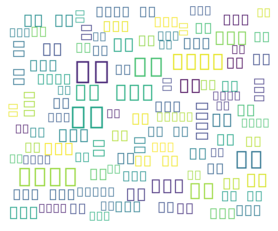

In [10]:
word_cloud = WordCloud(width=850, height = 700, max_font_size = 100, max_words = 100, background_color = "white").generate(' '.join(qs_new['cln_tokenized_overall_satisfaction_reason']))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()